# NEPA Delays Figure Code

In this notebook we use the datasets generated in Struthers-NEPA-Delays-Data-Subsetting-Code.ipynb to complete:
1. Mann-Whitney U tests
2. the survival analysis
3. create figures which are then imported into Illustrator for final adjustments. 

In this notebook we are remove a few more projects from the data sets.

We also create the time variables needed to successfully complete a survival analysis (Figure 1). 

We also split the data by NEPA type, complete statistical comparisons (Mann-Whitney U tests), and identify and remove outliers of the project footprint (Figure 2 panel A), and generate box-plots (Figure 2). 

These figures are exported as pdfs and imported into Illustrator to adjust colors, make some plots inserts in other plots, and adjust the axes labels, the figure titles, and the font size of the axes ticks.

## 1. Load the appropriate libraries and read in the csv files

In [1]:
# Download the relevant libraries
#import simpledbf # for converting dbf files to csv
#from simpledbf import Dbf5 # for converting dbf files to csv
import pandas as pd #For working with dataframes
import numpy as np #For working with arrays
import datetime as dt #For converting dates to serial datetimes
import matplotlib.pyplot as plt # for plotting and visualization
import seaborn as sns # for plotting and visualization
#import geopandas as gpd

#from dbfread import DBF

import sys
import time 
from tqdm.notebook import tqdm, trange

pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 190)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

from survive import KaplanMeier

In [3]:
# Set data directory
raw_data_dir = '/Users/kathrynmurenbeeld/CODING/FOREST-TREATMENTS/DATA/FOREST-TREATMENTS/RAW/'
proj_area_dir = '/Users/kathrynmurenbeeld/Desktop/FS_DATA/'
#data_dir = '/Users/kathrynmurenbeeld/Desktop/NEPA_DELAYS/Drafts/'

Please note the two datasets. The first dataset (df) was generated from the FACTS dataset without the shannon index. This is a more complete dataset as not all FACTS projects have geometries attributed to their activities.

The more complete FACTS data set (df) will be used for the survival analysis (figure 1) and the project richness measure (figure 2b).

The FACTS dataset with a calculated project "footprint" (df_foot) will be used for figure 2a.

In [4]:
# Load the data sets to make figures out of

# PALS+FACTS: NEPA init 2009-01-01 to 2021-12-31, all project purposes - version 2, with planned total project lifespan
df = pd.read_csv(raw_data_dir + 'df_pals_comm_NEPA_init_2009_2018_noneg_allpurp_v02_c20221208.csv') # this must have been named incorrectly. 
# it has the same number of projects (n=4716) and same number of CE, EA, and EISs as df_pals_comm_NEPA_init_2009_2021_noneg_allpurp_c20221202.csv
# also the maximum NEPA inititation date is 2021-07-13

#PALS+FACTS: NEPA init 2009-2021, all project purposes - calculated project footprint
df_foot = pd.read_csv(raw_data_dir + "df_pals_comm_NEPA_init_2009_2021_allpurp_footprint_c20230123.csv")


In [5]:
df.head(2)

,FOREST_ID,NEPA_DOC_NBR,PROJECT NAME,LMU (ACTUAL),LMU – REGION,LMU – FOREST,LMU – DISTRICT,PROJECT STATUS,PROJECT CREATED,CREATED FY,DECISION ID,DECISION NAME,INITIATION DATE,INITIATION FY,DECISION SIGNED,SIGNED FY,SIGNER LAST NAME,SIGNER FIRST NAME,SIGNER TITLE,DECISION TYPE,DECISION APPEAL RULE,PROJECT NOTICE AND COMMENT REGULATION,APPEALED OR OBJECTED?,NO COMMENTS OR ONLY SUPPORT?,LITIGATED?,FC Facility management – purpose,FR Research – purpose,HF Fuels management – purpose,HR Heritage resource management – purpose,LM Land ownership management – purpose,LW Land acquisition – purpose,MG Minerals and geology – purpose,PN Land management planning – purpose,RD Road management – purpose,RG Grazing management – purpose,"RO Regulations, directives, orders – purpose",RU Special area management – purpose,RW Recreation management – purpose,SU Special use management – purpose,TM Forest products – purpose,VM Vegetation management (non-forest products) – purpose,"WF Wildlife, fish, rare plants – purpose",WM Water management – purpose,AL Land use adjustments – activity,BL Boundary adjustments – activity,BM Biomass – activity,CP Plan creation/revision – activity,DC Directive creation/modification – activity,DR Road decommissioning – activity,DS Developed site management – activity,EC Environmental compliance actions – activity,ET Electric transmission – activity,"FACTS Activity (0,1)",FI Facility improvements/construction – activity,FN Fuel treatments – activity,FV Forest vegetation improvements – activity,GA Dispersed recreation management – activity,GP Grazing allotment management – activity,GR Grazing authorizations – activity,GT Geothermal – activity,HI Species habitat improvements – activity,HP Hydropower – activity,HR Heritage resource management – activity,LA Special use authorizations – activity,LP Land purchases – activity,MF Facility maintenance – activity,ML Abandoned mine land clean-up – activity,MO Minerals or geology plans of operations – activity,MP Plan amendment – activity,MT Trail management – activity,NC Special products sales – activity,NG Natural gas – activity,NW Noxious weed treatments – activity,OC Order creation/modification – activity,OL Oil – activity,PE Species population enhancements – activity,PJ Land exchanges – activity,RA Roadless area management – activity,RC Regulation creation/modification – activity,RD Road maintenance – activity,RE Research and development – activity,RI Road improvements/construction – activity,RV Rangeland vegetation improvements – activity,SA Special area management – activity,SC Scenery management – activity,SI Grazing structural improvements – activity,SL Solar – activity,SS Timber sales (salvage) – activity,TR Travel management – activity,TS Timber sales (green) – activity,WC Watershed improvements – activity,WD Wilderness management – activity,WI Wind – activity,UNIQUE PROJECT?,ELAPSED DAYS,UNIQUE DECISION?,ongoing,DISTRICT_ID,REGION_ID,DECISION_LEVEL,RegionName,forest,calendarYearSigned,calendarYearInitiated,H,projarea_x,E,projarea_y,D,NEPA_SIGNED_DATE,REGION,DATE_COMP_MIN,DATE_COMP_MAX,PROJECT_DUR_CURRENT,PERCENT_PROJ_COMP,DATE_AWARD_MIN,DATE_AWARD_MAX,FY_AWARD_MIN,FY_AWARD_MAX,FY_PLAN_MIN,FY_PLAN_MAX,FY_COMP_MIN,FY_COMP_MAX,PROJECT_DUR_PLAN_YR,ACT_AREA_DIFF,TOT_AREA_PLAN,TOT_AREA_COMP,NBR_ACTIVITIES,FIRE,RANGE,REC,TIMBER,SAW,WILDLIFE,RESTORE,MISC,ENGI,RICHNESS_TEST,PLAN_TO_AWARD_AVE,PLAN_TO_COMP_AVE,FIRST_ACTIVITY,LAST_ACTIVITY,FIRE_AVE_AREA,RANGE_AVE_AREA,REC_AVE_AREA,TIMBER_AVE_AREA,SAW_AVE_AREA,WILDLIFE_AVE_AREA,RESTORE_AVE_AREA,MISC_AVE_AREA,ENGI_AVE_AREA,PROJ_RICHNESS,PROJ_DIVERSE,PROJ_EVENNESS,AREA_RICHNESS,AREA_DIVERSE,AREA_EVENNESS,TOTAL_PROJECT_DAYS,TOTAL_PROJECT_PLAN_FY,NEPA_TO_LAST_ACT,NEPA_TO_FIRST_ACT,NEPA_TO_CONTRACT
0,102.0,47722,Supplemental EIS - BDNF Land & Resource Manage...,Beaverhead-Deerlodge National Forest All Units...,R1,BDNF,Beaverhead-Deerlodge National Forest All Units...,Complete,09/14/2015,2015.0,46316.0,Supplemental EIS - BDNF Land & Resource M

In [6]:
# Check the lengths of the two data sets.
print(len(df))
print(len(df_foot))

4716
4196


In [7]:
# Check the data types. Look for objects that should be datetimes.
df.dtypes
#df_foot.dtypes

FOREST_ID                                                   float64
NEPA_DOC_NBR                                                  int64
PROJECT NAME                                                 object
LMU (ACTUAL)                                                 object
LMU – REGION                                                 object
LMU – FOREST                                                 object
LMU – DISTRICT                                               object
PROJECT STATUS                                               object
PROJECT CREATED                                              object
CREATED FY                                                  float64
DECISION ID                                                 float64
DECISION NAME                                                object
INITIATION DATE                                              object
INITIATION FY                                               float64
DECISION SIGNED                                 

In [8]:
print(df['INITIATION DATE'].min())
print(df['INITIATION DATE'].max())

2009-01-01
2021-07-13


In [9]:
df_foot.head(2)

,FOREST_ID,NEPA_DOC_NBR,PROJECT NAME,LMU (ACTUAL),LMU – REGION,LMU – FOREST,LMU – DISTRICT,PROJECT STATUS,PROJECT CREATED,CREATED FY,DECISION ID,DECISION NAME,INITIATION DATE,INITIATION FY,DECISION SIGNED,SIGNED FY,SIGNER LAST NAME,SIGNER FIRST NAME,SIGNER TITLE,DECISION TYPE,DECISION APPEAL RULE,PROJECT NOTICE AND COMMENT REGULATION,APPEALED OR OBJECTED?,NO COMMENTS OR ONLY SUPPORT?,LITIGATED?,FC Facility management – purpose,FR Research – purpose,HF Fuels management – purpose,HR Heritage resource management – purpose,LM Land ownership management – purpose,LW Land acquisition – purpose,MG Minerals and geology – purpose,PN Land management planning – purpose,RD Road management – purpose,RG Grazing management – purpose,"RO Regulations, directives, orders – purpose",RU Special area management – purpose,RW Recreation management – purpose,SU Special use management – purpose,TM Forest products – purpose,VM Vegetation management (non-forest products) – purpose,"WF Wildlife, fish, rare plants – purpose",WM Water management – purpose,AL Land use adjustments – activity,BL Boundary adjustments – activity,BM Biomass – activity,CP Plan creation/revision – activity,DC Directive creation/modification – activity,DR Road decommissioning – activity,DS Developed site management – activity,EC Environmental compliance actions – activity,ET Electric transmission – activity,"FACTS Activity (0,1)",FI Facility improvements/construction – activity,FN Fuel treatments – activity,FV Forest vegetation improvements – activity,GA Dispersed recreation management – activity,GP Grazing allotment management – activity,GR Grazing authorizations – activity,GT Geothermal – activity,HI Species habitat improvements – activity,HP Hydropower – activity,HR Heritage resource management – activity,LA Special use authorizations – activity,LP Land purchases – activity,MF Facility maintenance – activity,ML Abandoned mine land clean-up – activity,MO Minerals or geology plans of operations – activity,MP Plan amendment – activity,MT Trail management – activity,NC Special products sales – activity,NG Natural gas – activity,NW Noxious weed treatments – activity,OC Order creation/modification – activity,OL Oil – activity,PE Species population enhancements – activity,PJ Land exchanges – activity,RA Roadless area management – activity,RC Regulation creation/modification – activity,RD Road maintenance – activity,RE Research and development – activity,RI Road improvements/construction – activity,RV Rangeland vegetation improvements – activity,SA Special area management – activity,SC Scenery management – activity,SI Grazing structural improvements – activity,SL Solar – activity,SS Timber sales (salvage) – activity,TR Travel management – activity,TS Timber sales (green) – activity,WC Watershed improvements – activity,WD Wilderness management – activity,WI Wind – activity,UNIQUE PROJECT?,ELAPSED DAYS,UNIQUE DECISION?,ongoing,DISTRICT_ID,REGION_ID,DECISION_LEVEL,RegionName,forest,calendarYearSigned,calendarYearInitiated,numact,H,projarea,footprint,E,NEPA_SIGNED_DATE,REGION,DATE_COMP_MIN,DATE_COMP_MAX,PROJECT_DUR_CURRENT,PERCENT_PROJ_COMP,DATE_AWARD_MIN,DATE_AWARD_MAX,FY_AWARD_MIN,FY_AWARD_MAX,FY_PLAN_MIN,FY_PLAN_MAX,FY_COMP_MIN,FY_COMP_MAX,PROJECT_DUR_PLAN_YR,ACT_AREA_DIFF,TOT_AREA_PLAN,TOT_AREA_COMP,NBR_ACTIVITIES,FIRE,RANGE,REC,TIMBER,SAW,WILDLIFE,RESTORE,MISC,ENGI,RICHNESS_TEST,PLAN_TO_AWARD_AVE,PLAN_TO_COMP_AVE,FIRST_ACTIVITY,LAST_ACTIVITY,FIRE_AVE_AREA,RANGE_AVE_AREA,REC_AVE_AREA,TIMBER_AVE_AREA,SAW_AVE_AREA,WILDLIFE_AVE_AREA,RESTORE_AVE_AREA,MISC_AVE_AREA,ENGI_AVE_AREA,PROJ_RICHNESS,PROJ_DIVERSE,PROJ_EVENNESS,AREA_RICHNESS,AREA_DIVERSE,AREA_EVENNESS,TOTAL_PROJECT_DAYS,TOTAL_PROJECT_PLAN_FY,NEPA_TO_LAST_ACT,NEPA_TO_FIRST_ACT,NEPA_TO_CONTRACT
0,102.0,47722,Supplemental EIS - BDNF Land & Resource Manage...,Beaverhead-Deerlodge National Forest All Units...,R1,BDNF,Beaverhead-Deerlodge National Forest All Units...,Complete,09/14/2015,2015.0,46316.0,Supplemental EIS - BDNF Land & Resource

In [10]:
print("df" + "\n" + str(df['DECISION TYPE'].value_counts()))
print("df_foot" + "\n" + str(df_foot['DECISION TYPE'].value_counts()))

df
DM     2909
DN     1621
ROD     186
Name: DECISION TYPE, dtype: int64
df_foot
DM     2509
DN     1512
ROD     175
Name: DECISION TYPE, dtype: int64


## 2. Create Varaibles for the Survival Analysis

In [11]:
# For the elapsed days, fill in na with 0s

df['ELAPSED DAYS'] = df['ELAPSED DAYS'].fillna(0)
df_foot['ELAPSED DAYS'] = df_foot['ELAPSED DAYS'].fillna(0)

In [12]:
# Convert date objects/strings to datetime

df['INITIATION DATE'] = pd.to_datetime(df['INITIATION DATE'])
df['DECISION SIGNED'] = pd.to_datetime(df['DECISION SIGNED'])
df['DATE_COMP_MIN'] = pd.to_datetime(df['DATE_COMP_MIN'])
df['DATE_COMP_MAX'] = pd.to_datetime(df['DATE_COMP_MAX'])
df['DATE_AWARD_MIN'] = pd.to_datetime(df['DATE_AWARD_MIN'])
df['DATE_AWARD_MAX'] = pd.to_datetime(df['DATE_AWARD_MAX'])
df['NEPA_SIGNED_DATE'] = pd.to_datetime(df['NEPA_SIGNED_DATE'])

df_foot['INITIATION DATE'] = pd.to_datetime(df_foot['INITIATION DATE'])
df_foot['DECISION SIGNED'] = pd.to_datetime(df_foot['DECISION SIGNED'])
df_foot['DATE_COMP_MIN'] = pd.to_datetime(df_foot['DATE_COMP_MIN'])
df_foot['DATE_COMP_MAX'] = pd.to_datetime(df_foot['DATE_COMP_MAX'])
df_foot['DATE_AWARD_MIN'] = pd.to_datetime(df_foot['DATE_AWARD_MIN'])
df_foot['DATE_AWARD_MAX'] = pd.to_datetime(df_foot['DATE_AWARD_MAX'])
df_foot['NEPA_SIGNED_DATE'] = pd.to_datetime(df_foot['NEPA_SIGNED_DATE'])



For the survival analysis, one needs time to event values that includes the full time of observation for censored projects. 

A maximum time will be used for those censored projects, those projects that have not been initiated yet (i.e. do not have at least one activity in the project has a date completed) or awarded yet (i.e. do not have at least one activity in the project has a date awarded. 

Here the max date is 2022-07-08.

In [13]:
df['ASSESSMENT_TIME'] = np.where(df['ELAPSED DAYS'] == 0.0, df['NEPA_SIGNED_DATE'] - df['INITIATION DATE'], 
                                     df['DECISION SIGNED'] - df['INITIATION DATE'])

df_foot['ASSESSMENT_TIME'] = np.where(df_foot['ELAPSED DAYS'] == 0.0, df_foot['NEPA_SIGNED_DATE'] - df_foot['INITIATION DATE'], 
                                     df_foot['DECISION SIGNED'] - df_foot['INITIATION DATE'])


In [14]:
df['NEPA_TO_LAST_ACT_0'] = df['NEPA_TO_LAST_ACT'].fillna(0)

df_foot['NEPA_TO_LAST_ACT_0'] = df_foot['NEPA_TO_LAST_ACT'].fillna(0)


In [15]:
# Use NEPA_SIGNED_DATE
# But for the 24 projects that end up with NAN for NEPA_TO_FIRST_ACT/CONTRACT_MAX need to use DECISION SIGNED

max_time = df['DATE_COMP_MAX'].max()
max_time_ft = df_foot['DATE_COMP_MAX'].max()

df['IMPLEMENTATION_TIME'] = np.where(df['NEPA_TO_LAST_ACT_0'] == 0.0, max_time - df['NEPA_SIGNED_DATE'], 
                                     df['DATE_COMP_MAX'] - df['DECISION SIGNED'])
df_foot['IMPLEMENTATION_TIME'] = np.where(df_foot['NEPA_TO_LAST_ACT_0'] == 0.0, max_time - df_foot['NEPA_SIGNED_DATE'], 
                                     df_foot['DATE_COMP_MAX'] - df_foot['DECISION SIGNED'])


In [16]:
df['NEPA_TO_FIRST_ACT_0'] = df['NEPA_TO_FIRST_ACT'].fillna(0)
df_foot['NEPA_TO_FIRST_ACT_0'] = df_foot['NEPA_TO_FIRST_ACT'].fillna(0)


In [17]:
df['NEPA_TO_FIRST_ACT_MAX'] = np.where(df['NEPA_TO_FIRST_ACT_0'] == 0.0, max_time - df['NEPA_SIGNED_DATE'], 
                                     df['DATE_COMP_MIN'] - df['DECISION SIGNED'])

df['NEPA_TO_FIRST_ACT_MAX'] = np.where(df['NEPA_TO_FIRST_ACT_MAX'].isna(), max_time - df['DECISION SIGNED'], 
                                     df['NEPA_TO_FIRST_ACT_MAX'])

df_foot['NEPA_TO_FIRST_ACT_MAX'] = np.where(df_foot['NEPA_TO_FIRST_ACT_0'] == 0.0, max_time_ft - df_foot['NEPA_SIGNED_DATE'], 
                                     df_foot['DATE_COMP_MIN'] - df_foot['DECISION SIGNED'])

df_foot['NEPA_TO_FIRST_ACT_MAX'] = np.where(df_foot['NEPA_TO_FIRST_ACT_MAX'].isna(), max_time_ft - df_foot['DECISION SIGNED'], 
                                     df_foot['NEPA_TO_FIRST_ACT_MAX'])


In [18]:
df['NEPA_TO_CONTRACT_0'] = df['NEPA_TO_CONTRACT'].fillna(0)
df_foot['NEPA_TO_CONTRACT_0'] = df_foot['NEPA_TO_CONTRACT'].fillna(0)


In [19]:
df['NEPA_TO_CONTRACT_MAX'] = np.where(df['NEPA_TO_CONTRACT_0'] == 0.0, (max_time - df['NEPA_SIGNED_DATE']), 
                                     (df['DATE_AWARD_MIN'] - df['DECISION SIGNED']))
df['NEPA_TO_CONTRACT_MAX'] = np.where(df['NEPA_TO_CONTRACT_MAX'].isna(), max_time - df['DECISION SIGNED'], 
                                     df['NEPA_TO_CONTRACT_MAX'])

df_foot['NEPA_TO_CONTRACT_MAX'] = np.where(df_foot['NEPA_TO_CONTRACT_0'] == 0.0, (max_time_ft - df_foot['NEPA_SIGNED_DATE']), 
                                     (df_foot['DATE_AWARD_MIN'] - df_foot['DECISION SIGNED']))
df_foot['NEPA_TO_CONTRACT_MAX'] = np.where(df_foot['NEPA_TO_CONTRACT_MAX'].isna(), max_time_ft - df_foot['DECISION SIGNED'], 
                                     df_foot['NEPA_TO_CONTRACT_MAX'])


In [20]:
df['TOTAL_PROJECT_DAYS_0'] = df['TOTAL_PROJECT_DAYS'].fillna(0)
df_foot['TOTAL_PROJECT_DAYS_0'] = df_foot['TOTAL_PROJECT_DAYS'].fillna(0)


In [21]:
df['TOTAL_PROJECT_DAYS_MAX'] = np.where(df['TOTAL_PROJECT_DAYS_0'] == 0.0, (max_time - df['INITIATION DATE']),
                                       df['DATE_COMP_MAX'] - df['INITIATION DATE'])

df_foot['TOTAL_PROJECT_DAYS_MAX'] = np.where(df_foot['TOTAL_PROJECT_DAYS_0'] == 0.0, (max_time_ft - df_foot['INITIATION DATE']),
                                       df_foot['DATE_COMP_MAX'] - df_foot['INITIATION DATE'])


In [22]:
# Convert all time deltas to floats

df['ASSESSMENT_TIME'] = pd.to_numeric(df['ASSESSMENT_TIME'].dt.days, downcast='integer')
df['IMPLEMENTATION_TIME'] = pd.to_numeric(df['IMPLEMENTATION_TIME'].dt.days, downcast='integer')
df['NEPA_TO_FIRST_ACT_MAX'] = pd.to_numeric(df['NEPA_TO_FIRST_ACT_MAX'].dt.days, downcast='integer')
df['NEPA_TO_CONTRACT_MAX'] = pd.to_numeric(df['NEPA_TO_CONTRACT_MAX'].dt.days, downcast='integer')
df['TOTAL_PROJECT_DAYS_MAX'] = pd.to_numeric(df['TOTAL_PROJECT_DAYS_MAX'].dt.days, downcast='integer')

df_foot['ASSESSMENT_TIME'] = pd.to_numeric(df_foot['ASSESSMENT_TIME'].dt.days, downcast='integer')
df_foot['IMPLEMENTATION_TIME'] = pd.to_numeric(df_foot['IMPLEMENTATION_TIME'].dt.days, downcast='integer')
df_foot['NEPA_TO_FIRST_ACT_MAX'] = pd.to_numeric(df_foot['NEPA_TO_FIRST_ACT_MAX'].dt.days, downcast='integer')
df_foot['NEPA_TO_CONTRACT_MAX'] = pd.to_numeric(df_foot['NEPA_TO_CONTRACT_MAX'].dt.days, downcast='integer')
df_foot['TOTAL_PROJECT_DAYS_MAX'] = pd.to_numeric(df_foot['TOTAL_PROJECT_DAYS_MAX'].dt.days, downcast='integer')


A survival analysis also requires a binary variable that shows whether the event of interest (e.g. NEPA sigend, the first activity is completed, a contract is awarded, or the last activity in the project is completed) has occurred. 0 means the event has not occurred. 1 means the event has occurred.

Please note that for this research we did not use the event for project completion (i.e. the last activity in a project has occurred). 

In [23]:

df['NEPA_COMP2'] = np.where(df['ASSESSMENT_TIME'] > 0, True, False)
#df['NEPA_COMP'] = np.where((df['SIGNED FY'] > 0.0) , True, False)
df['PROJ_INIT'] = np.where(df['NEPA_TO_FIRST_ACT'].isna(), False, True)
df['PROJ_AWARDED'] = np.where(df['NEPA_TO_CONTRACT'].isna(), False, True)
df['PROJ_COMP'] = np.where(df['PERCENT_PROJ_COMP'] == 1.0, True, False)

df_foot['NEPA_COMP2'] = np.where(df_foot['ASSESSMENT_TIME'] > 0, True, False)
#df_foot['NEPA_COMP'] = np.where((df_foot['SIGNED FY'] > 0.0) , True, False)
df_foot['PROJ_INIT'] = np.where(df_foot['NEPA_TO_FIRST_ACT'].isna(), False, True)
df_foot['PROJ_AWARDED'] = np.where(df_foot['NEPA_TO_CONTRACT'].isna(), False, True)
df_foot['PROJ_COMP'] = np.where(df_foot['PERCENT_PROJ_COMP'] == 1.0, True, False)


Again, censoring in a survival analysis here refers to projects with events that have not occurred by the end of the observation period (the max date 2022-07-08). 

The values below show that many projects have not been completed by the end of the observation periodp. 

In [24]:
print("Censored NEPA assessments: " + str(len(df[df['NEPA_COMP2'] == False])))
print("Censored Project initiation: " + str(len(df[df['PROJ_INIT'] == False])))
print("Censored Project awarded: " + str(len(df[df['PROJ_AWARDED'] == False])))
print("Censored Project completion: " + str(len(df[df['PROJ_COMP'] == False])))

Censored NEPA assessments: 10
Censored Project initiation: 589
Censored Project awarded: 314
Censored Project completion: 3151


In [25]:
print("Censored NEPA assessments: " + str(len(df_foot[df_foot['NEPA_COMP2'] == False])))
print("Censored Project initiation: " + str(len(df_foot[df_foot['PROJ_INIT'] == False])))
print("Censored Project awarded: " + str(len(df_foot[df_foot['PROJ_AWARDED'] == False])))
print("Censored Project completion: " + str(len(df_foot[df_foot['PROJ_COMP'] == False])))


Censored NEPA assessments: 9
Censored Project initiation: 380
Censored Project awarded: 140
Censored Project completion: 2847


In [26]:
print(len(df[df['NEPA_TO_FIRST_ACT_MAX'].isna()]))
print(len(df_foot[df_foot['NEPA_TO_FIRST_ACT_MAX'].isna()]))

0
0


There may still be some projects with dates for events pre-NEPA signature. These projects will be removed from the datasets. 

In [27]:
print(len(df[df['NEPA_TO_FIRST_ACT_MAX'] <0]))
print(len(df_foot[df_foot['NEPA_TO_FIRST_ACT_MAX'] <0]))

16
16


In [28]:
print(len(df[df['NEPA_TO_CONTRACT_MAX'] <0]))
print(len(df_foot[df_foot['NEPA_TO_CONTRACT_MAX'] <0]))

21
21


In [29]:
# Create dataframes with these projects removed.

df_noneg = df.loc[(df['NEPA_TO_FIRST_ACT_MAX'] >= 0) | (df['NEPA_TO_FIRST_ACT_MAX'].isna())].copy()
df_noneg = df.loc[(df['NEPA_TO_CONTRACT_MAX'] >= 0) | (df['NEPA_TO_CONTRACT_MAX'].isna())].copy()

df_foot_noneg = df_foot.loc[(df['NEPA_TO_FIRST_ACT_MAX'] >= 0) | (df_foot['NEPA_TO_FIRST_ACT_MAX'].isna())].copy()
df_foot_noneg = df_foot.loc[(df_foot['NEPA_TO_CONTRACT_MAX'] >= 0) | (df_foot['NEPA_TO_CONTRACT_MAX'].isna())].copy()


In [30]:
print(len(df_noneg))
print(len(df_foot_noneg))

4695
4175


Check to see the differences in the datasets between the full FACTS data and the FACTS data with project "footprints". How many projects don't have geometries? What types of projects don't have geometries?

In [31]:
df_projs = list(df['NEPA_DOC_NBR'].unique())
df_foot_projs = list(df_foot['NEPA_DOC_NBR'].unique())


df_noneg_projs = list(df_noneg['NEPA_DOC_NBR'].unique())
df_foot_noneg_projs = list(df_foot_noneg['NEPA_DOC_NBR'].unique())

In [32]:
missing_facts_projs_df_foot = list(set(df_noneg_projs) - set(df_foot_noneg_projs))

In [33]:
print("There are " + str(len(missing_facts_projs_df_foot)) + " projects in the FACTS dataset that do not have footprints")
      
      
      

There are 520 projects in the FACTS dataset that do not have footprints


In [34]:
df_missing_projs_df_foot = df_noneg[df_noneg['NEPA_DOC_NBR'].isin(missing_facts_projs_df_foot)]

In [35]:
df_missing_projs_df_foot['DECISION TYPE'].value_counts()

DM     400
DN     109
ROD     11
Name: DECISION TYPE, dtype: int64

In [36]:
# Of those missing projects, how many only had one activity?
len(df_missing_projs_df_foot.loc[df_missing_projs_df_foot['NBR_ACTIVITIES'] == 1.0])

168

What about projects that are in PALS and have geometries but are not in the FACTS data set?

In [37]:
df_merge = pd.merge(df_foot, df, how="left", on="NEPA_DOC_NBR")

In [38]:
len(df_merge)

4196

In [39]:
df_merge = df_merge[df_merge['FIRE_x'].notna()].copy()
len(df_merge)

4163

In [40]:
df_merge_projs = list(df_merge['NEPA_DOC_NBR'].unique())

In [41]:
len(df_merge_projs)

4163

In [42]:
missing_facts_projs = list(set(df_foot_noneg_projs) - set(df_merge_projs))

In [43]:
#missing_facts_projs

In [44]:
df_missing_facts_projs = df_foot[df_foot['NEPA_DOC_NBR'].isin(missing_facts_projs)]

In [45]:
df_missing_facts_projs['DECISION TYPE'].value_counts()

DM    30
DN     3
Name: DECISION TYPE, dtype: int64

## 3. Remove the projects with negative "event" values

These are projects in which the first contract awarded or the first activity in the data set occurred *before* NEPA was signed. 

In [46]:
df = df.loc[(df['NEPA_TO_FIRST_ACT_MAX'] >= 0) | (df['NEPA_TO_FIRST_ACT_MAX'].isna())].copy()
df = df.loc[(df['NEPA_TO_CONTRACT_MAX'] >= 0) | (df['NEPA_TO_CONTRACT_MAX'].isna())].copy()

df_foot = df_foot.loc[(df_foot['NEPA_TO_FIRST_ACT_MAX'] >= 0) | (df_foot['NEPA_TO_FIRST_ACT_MAX'].isna())].copy()
df_foot = df_foot.loc[(df_foot['NEPA_TO_CONTRACT_MAX'] >= 0) | (df_foot['NEPA_TO_CONTRACT_MAX'].isna())].copy()

In [47]:
len(df_foot)

4175

In [48]:
#Also remove the 33 projects that are in the df_foot_noneg but not in df_noneg

df_foot = df_foot[~df_foot['NEPA_DOC_NBR'].isin(missing_facts_projs)]


In [49]:
len(df_foot)

4142

In [50]:
df_projs = list(df['NEPA_DOC_NBR'].unique())
df_foot_projs = list(df_foot['NEPA_DOC_NBR'].unique())


df_noneg_projs = list(df_noneg['NEPA_DOC_NBR'].unique())
df_foot_noneg_projs = list(df_foot_noneg['NEPA_DOC_NBR'].unique())

In [51]:
missing_facts_projs_df_foot = list(set(df_noneg_projs) - set(df_foot_noneg_projs))

In [52]:
df_missing_projs_df_foot = df_noneg[df_noneg['NEPA_DOC_NBR'].isin(missing_facts_projs_df_foot)]

In [53]:
df_missing_projs_df_foot.head(1)

,FOREST_ID,NEPA_DOC_NBR,PROJECT NAME,LMU (ACTUAL),LMU – REGION,LMU – FOREST,LMU – DISTRICT,PROJECT STATUS,PROJECT CREATED,CREATED FY,DECISION ID,DECISION NAME,INITIATION DATE,INITIATION FY,DECISION SIGNED,SIGNED FY,SIGNER LAST NAME,SIGNER FIRST NAME,SIGNER TITLE,DECISION TYPE,DECISION APPEAL RULE,PROJECT NOTICE AND COMMENT REGULATION,APPEALED OR OBJECTED?,NO COMMENTS OR ONLY SUPPORT?,LITIGATED?,FC Facility management – purpose,FR Research – purpose,HF Fuels management – purpose,HR Heritage resource management – purpose,LM Land ownership management – purpose,LW Land acquisition – purpose,MG Minerals and geology – purpose,PN Land management planning – purpose,RD Road management – purpose,RG Grazing management – purpose,"RO Regulations, directives, orders – purpose",RU Special area management – purpose,RW Recreation management – purpose,SU Special use management – purpose,TM Forest products – purpose,VM Vegetation management (non-forest products) – purpose,"WF Wildlife, fish, rare plants – purpose",WM Water management – purpose,AL Land use adjustments – activity,BL Boundary adjustments – activity,BM Biomass – activity,CP Plan creation/revision – activity,DC Directive creation/modification – activity,DR Road decommissioning – activity,DS Developed site management – activity,EC Environmental compliance actions – activity,ET Electric transmission – activity,"FACTS Activity (0,1)",FI Facility improvements/construction – activity,FN Fuel treatments – activity,FV Forest vegetation improvements – activity,GA Dispersed recreation management – activity,GP Grazing allotment management – activity,GR Grazing authorizations – activity,GT Geothermal – activity,HI Species habitat improvements – activity,HP Hydropower – activity,HR Heritage resource management – activity,LA Special use authorizations – activity,LP Land purchases – activity,MF Facility maintenance – activity,ML Abandoned mine land clean-up – activity,MO Minerals or geology plans of operations – activity,MP Plan amendment – activity,MT Trail management – activity,NC Special products sales – activity,NG Natural gas – activity,NW Noxious weed treatments – activity,OC Order creation/modification – activity,OL Oil – activity,PE Species population enhancements – activity,PJ Land exchanges – activity,RA Roadless area management – activity,RC Regulation creation/modification – activity,RD Road maintenance – activity,RE Research and development – activity,RI Road improvements/construction – activity,RV Rangeland vegetation improvements – activity,SA Special area management – activity,SC Scenery management – activity,SI Grazing structural improvements – activity,SL Solar – activity,SS Timber sales (salvage) – activity,TR Travel management – activity,TS Timber sales (green) – activity,WC Watershed improvements – activity,WD Wilderness management – activity,WI Wind – activity,UNIQUE PROJECT?,ELAPSED DAYS,UNIQUE DECISION?,ongoing,DISTRICT_ID,REGION_ID,DECISION_LEVEL,RegionName,forest,calendarYearSigned,calendarYearInitiated,H,projarea_x,E,projarea_y,D,NEPA_SIGNED_DATE,REGION,DATE_COMP_MIN,DATE_COMP_MAX,PROJECT_DUR_CURRENT,PERCENT_PROJ_COMP,DATE_AWARD_MIN,DATE_AWARD_MAX,FY_AWARD_MIN,FY_AWARD_MAX,FY_PLAN_MIN,FY_PLAN_MAX,FY_COMP_MIN,FY_COMP_MAX,PROJECT_DUR_PLAN_YR,ACT_AREA_DIFF,TOT_AREA_PLAN,TOT_AREA_COMP,NBR_ACTIVITIES,FIRE,RANGE,REC,TIMBER,SAW,WILDLIFE,RESTORE,MISC,ENGI,RICHNESS_TEST,PLAN_TO_AWARD_AVE,PLAN_TO_COMP_AVE,FIRST_ACTIVITY,LAST_ACTIVITY,FIRE_AVE_AREA,RANGE_AVE_AREA,REC_AVE_AREA,TIMBER_AVE_AREA,SAW_AVE_AREA,WILDLIFE_AVE_AREA,RESTORE_AVE_AREA,MISC_AVE_AREA,ENGI_AVE_AREA,PROJ_RICHNESS,PROJ_DIVERSE,PROJ_EVENNESS,AREA_RICHNESS,AREA_DIVERSE,AREA_EVENNESS,TOTAL_PROJECT_DAYS,TOTAL_PROJECT_PLAN_FY,NEPA_TO_LAST_ACT,NEPA_TO_FIRST_ACT,NEPA_TO_CONTRACT,ASSESSMENT_TIME,NEPA_TO_LAST_ACT_0,IMPLEMENTATION_TIME,NEPA_TO_FIRST_ACT_0,NEPA_TO_FIRST_ACT_MAX,NEPA_TO_CONTRACT_0,NEPA_TO_CONTRACT_MAX,TOTAL_PROJECT_DAYS_0,TOTAL_PROJECT_DAYS_MAX,NEPA_COMP2,PROJ_INIT,PROJ_AWARDED,PROJ_COMP
2,102.0,29118,Lima Tend

In [54]:
print("Censored NEPA assessments: " + str(len(df[df['NEPA_COMP2'] == False])))
print("Censored Project initiation: " + str(len(df[df['PROJ_INIT'] == False])))
print("Censored Project awarded: " + str(len(df[df['PROJ_AWARDED'] == False])))
print("Censored Project completion: " + str(len(df[df['PROJ_COMP'] == False])))

Censored NEPA assessments: 10
Censored Project initiation: 588
Censored Project awarded: 314
Censored Project completion: 3131


In [55]:
print("Censored NEPA assessments: " + str(len(df_foot[df_foot['NEPA_COMP2'] == False])))
print("Censored Project initiation: " + str(len(df_foot[df_foot['PROJ_INIT'] == False])))
print("Censored Project awarded: " + str(len(df_foot[df_foot['PROJ_AWARDED'] == False])))
print("Censored Project completion: " + str(len(df_foot[df_foot['PROJ_COMP'] == False])))

Censored NEPA assessments: 9
Censored Project initiation: 346
Censored Project awarded: 107
Censored Project completion: 2794


Make sure to convert the footprint from m^2 to hectares

In [56]:
# projarea (from shannindex_0120) is in m2, make sure to convert to hectares

df_foot['footprint'] = df_foot['footprint'] * 0.0001


For some of the figures, breaking out the data by NEPA will make the process easier.

In [57]:
df_dm = df.loc[df['DECISION TYPE'] == 'DM'].copy()

df_dn = df.loc[df['DECISION TYPE'] == 'DN'].copy()

df_rod = df.loc[df['DECISION TYPE'] == 'ROD'].copy()

df_foot_dm = df_foot.loc[df_foot['DECISION TYPE'] == 'DM'].copy()

df_foot_dn = df_foot.loc[df_foot['DECISION TYPE'] == 'DN'].copy()

df_foot_rod = df_foot.loc[df_foot['DECISION TYPE'] == 'ROD'].copy()


Create a variable of the NEPA Initiation year (**INITIATION_YR**) based on the NEPA **INITIATION DATE**.

In [58]:
df['INITIATION_YR'] = pd.DatetimeIndex(df['INITIATION DATE']).year

df_dm['INITIATION_YR'] = pd.DatetimeIndex(df_dm['INITIATION DATE']).year
df_dn['INITIATION_YR'] = pd.DatetimeIndex(df_dn['INITIATION DATE']).year
df_rod['INITIATION_YR'] = pd.DatetimeIndex(df_rod['INITIATION DATE']).year

df_foot['INITIATION_YR'] = pd.DatetimeIndex(df_foot['INITIATION DATE']).year

df_foot_dm['INITIATION_YR'] = pd.DatetimeIndex(df_foot_dm['INITIATION DATE']).year
df_foot_dn['INITIATION_YR'] = pd.DatetimeIndex(df_foot_dn['INITIATION DATE']).year
df_foot_rod['INITIATION_YR'] = pd.DatetimeIndex(df_foot_rod['INITIATION DATE']).year


Months will be easier to process visually/mentally. 

Create columns with all of the event duration varaibles converted to months.

In [59]:
df['ASSESSMENT_TIME_MNTH'] = df['ASSESSMENT_TIME'] / 365.25 * 12
df['IMPLEMENTATION_TIME_MNTH'] = df['IMPLEMENTATION_TIME'] / 365.25 * 12
df['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df['NEPA_TO_CONTRACT_MAX_MNTH'] = df['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df['NEPA_TO_FIRST_ACT_MNTH'] = df['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df['NEPA_TO_CONTRACT_MNTH'] = df['NEPA_TO_CONTRACT'] / 365.25 * 12
df['PROJECT_DUR_PLAN_MNTH'] = df['PROJECT_DUR_PLAN_YR'] *12
df['TOTAL_PROJ_MNTH'] = df['TOTAL_PROJECT_PLAN_FY'] * 12

df_foot['ASSESSMENT_TIME_MNTH'] = df_foot['ASSESSMENT_TIME'] / 365.25 * 12
df_foot['IMPLEMENTATION_TIME_MNTH'] = df_foot['IMPLEMENTATION_TIME'] / 365.25 * 12
df_foot['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df_foot['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df_foot['NEPA_TO_CONTRACT_MAX_MNTH'] = df_foot['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df_foot['NEPA_TO_FIRST_ACT_MNTH'] = df_foot['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df_foot['NEPA_TO_CONTRACT_MNTH'] = df_foot['NEPA_TO_CONTRACT'] / 365.25 * 12
df_foot['PROJECT_DUR_PLAN_MNTH'] = df_foot['PROJECT_DUR_PLAN_YR'] *12
df_foot['TOTAL_PROJ_MNTH'] = df_foot['TOTAL_PROJECT_PLAN_FY'] * 12

In [60]:
df_dm['ASSESSMENT_TIME_MNTH'] = df_dm['ASSESSMENT_TIME'] / 365.25 * 12
df_dm['IMPLEMENTATION_TIME_MNTH'] = df_dm['IMPLEMENTATION_TIME'] / 365.25 * 12
df_dm['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df_dm['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df_dm['NEPA_TO_CONTRACT_MAX_MNTH'] = df_dm['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df_dm['NEPA_TO_FIRST_ACT_MNTH'] = df_dm['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df_dm['NEPA_TO_CONTRACT_MNTH'] = df_dm['NEPA_TO_CONTRACT'] / 365.25 * 12
df_dm['PROJECT_DUR_PLAN_MNTH'] = df_dm['PROJECT_DUR_PLAN_YR'] *12
df_dm['TOTAL_PROJ_MNTH'] = df_dm['TOTAL_PROJECT_PLAN_FY'] * 12

df_dn['ASSESSMENT_TIME_MNTH'] = df_dn['ASSESSMENT_TIME'] / 365.25 * 12
df_dn['IMPLEMENTATION_TIME_MNTH'] = df_dn['IMPLEMENTATION_TIME'] / 365.25 * 12
df_dn['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df_dn['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df_dn['NEPA_TO_CONTRACT_MAX_MNTH'] = df_dn['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df_dn['NEPA_TO_FIRST_ACT_MNTH'] = df_dn['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df_dn['NEPA_TO_CONTRACT_MNTH'] = df_dn['NEPA_TO_CONTRACT'] / 365.25 * 12
df_dn['PROJECT_DUR_PLAN_MNTH'] = df_dn['PROJECT_DUR_PLAN_YR'] *12
df_dn['TOTAL_PROJ_MNTH'] = df_dn['TOTAL_PROJECT_PLAN_FY'] * 12

df_rod['ASSESSMENT_TIME_MNTH'] = df_rod['ASSESSMENT_TIME'] / 365.25 * 12
df_rod['IMPLEMENTATION_TIME_MNTH'] = df_rod['IMPLEMENTATION_TIME'] / 365.25 * 12
df_rod['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df_rod['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df_rod['NEPA_TO_CONTRACT_MAX_MNTH'] = df_rod['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df_rod['NEPA_TO_FIRST_ACT_MNTH'] = df_rod['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df_rod['NEPA_TO_CONTRACT_MNTH'] = df_rod['NEPA_TO_CONTRACT'] / 365.25 * 12
df_rod['PROJECT_DUR_PLAN_MNTH'] = df_rod['PROJECT_DUR_PLAN_YR'] *12
df_rod['TOTAL_PROJ_MNTH'] = df_rod['TOTAL_PROJECT_PLAN_FY'] * 12

df_foot_dm['ASSESSMENT_TIME_MNTH'] = df_foot_dm['ASSESSMENT_TIME'] / 365.25 * 12
df_foot_dm['IMPLEMENTATION_TIME_MNTH'] = df_foot_dm['IMPLEMENTATION_TIME'] / 365.25 * 12
df_foot_dm['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df_foot_dm['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df_foot_dm['NEPA_TO_CONTRACT_MAX_MNTH'] = df_foot_dm['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df_foot_dm['NEPA_TO_FIRST_ACT_MNTH'] = df_foot_dm['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df_foot_dm['NEPA_TO_CONTRACT_MNTH'] = df_foot_dm['NEPA_TO_CONTRACT'] / 365.25 * 12
df_foot_dm['PROJECT_DUR_PLAN_MNTH'] = df_foot_dm['PROJECT_DUR_PLAN_YR'] *12
df_foot_dm['TOTAL_PROJ_MNTH'] = df_foot_dm['TOTAL_PROJECT_PLAN_FY'] * 12

df_foot_dn['ASSESSMENT_TIME_MNTH'] = df_foot_dn['ASSESSMENT_TIME'] / 365.25 * 12
df_foot_dn['IMPLEMENTATION_TIME_MNTH'] = df_foot_dn['IMPLEMENTATION_TIME'] / 365.25 * 12
df_foot_dn['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df_foot_dn['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df_foot_dn['NEPA_TO_CONTRACT_MAX_MNTH'] = df_foot_dn['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df_foot_dn['NEPA_TO_FIRST_ACT_MNTH'] = df_foot_dn['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df_foot_dn['NEPA_TO_CONTRACT_MNTH'] = df_foot_dn['NEPA_TO_CONTRACT'] / 365.25 * 12
df_foot_dn['PROJECT_DUR_PLAN_MNTH'] = df_foot_dn['PROJECT_DUR_PLAN_YR'] *12
df_foot_dn['TOTAL_PROJ_MNTH'] = df_foot_dn['TOTAL_PROJECT_PLAN_FY'] * 12

df_foot_rod['ASSESSMENT_TIME_MNTH'] = df_foot_rod['ASSESSMENT_TIME'] / 365.25 * 12
df_foot_rod['IMPLEMENTATION_TIME_MNTH'] = df_foot_rod['IMPLEMENTATION_TIME'] / 365.25 * 12
df_foot_rod['NEPA_TO_FIRST_ACT_MAX_MNTH'] = df_foot_rod['NEPA_TO_FIRST_ACT_MAX'] / 365.25 * 12
df_foot_rod['NEPA_TO_CONTRACT_MAX_MNTH'] = df_foot_rod['NEPA_TO_CONTRACT_MAX'] / 365.25 * 12
df_foot_rod['NEPA_TO_FIRST_ACT_MNTH'] = df_foot_rod['NEPA_TO_FIRST_ACT'] / 365.25 * 12
df_foot_rod['NEPA_TO_CONTRACT_MNTH'] = df_foot_rod['NEPA_TO_CONTRACT'] / 365.25 * 12
df_foot_rod['PROJECT_DUR_PLAN_MNTH'] = df_foot_rod['PROJECT_DUR_PLAN_YR'] *12
df_foot_rod['TOTAL_PROJ_MNTH'] = df_foot_rod['TOTAL_PROJECT_PLAN_FY'] * 12


In [61]:
print(df['ASSESSMENT_TIME_MNTH'].mean())
print(df['TOTAL_PROJ_MNTH'].median())
print(df['PROJECT_DUR_PLAN_MNTH'].mean())

12.036179867174862
84.0
75.46981740064447


In [62]:
# I made this variable as a check for the median values
df_rod['TOTAL_PROJ_2'] = (df_rod['FY_PLAN_MAX'] - df_rod['INITIATION FY']) * 12

In [63]:
df_rod['TOTAL_PROJ_2'].median()

144.0

In [64]:
df_rod['TOTAL_PROJ_MNTH'].max()

1044.0

In [65]:
df_rod['PROJECT_DUR_PLAN_MNTH'].max()

1008.0

## 4. Print the median total project "lifespan" for each NEPA type (TOTAL_PROJ_MNTH).

The PROJECT_DUR_PLAN_MNTH is the planned duration of a project once NEPA is signed. 

In [66]:
print(df_dm['TOTAL_PROJ_MNTH'].median())
print(df_dm['PROJECT_DUR_PLAN_MNTH'].median())

print(df_dn['TOTAL_PROJ_MNTH'].median())
print(df_dn['PROJECT_DUR_PLAN_MNTH'].median())

print(df_rod['TOTAL_PROJ_MNTH'].median())
print(df_rod['PROJECT_DUR_PLAN_MNTH'].median())

60.0
36.0
132.0
108.0
144.0
108.0


In [67]:
print(df_dm['ASSESSMENT_TIME_MNTH'].median())
print(df_dn['ASSESSMENT_TIME_MNTH'].median())
print(df_rod['ASSESSMENT_TIME_MNTH'].median())

print(df_dm['NEPA_TO_FIRST_ACT_MAX_MNTH'].median())
print(df_dn['NEPA_TO_FIRST_ACT_MAX_MNTH'].median())
print(df_rod['NEPA_TO_FIRST_ACT_MAX_MNTH'].median())

print(df_dm['NEPA_TO_CONTRACT_MAX_MNTH'].median())
print(df_dn['NEPA_TO_CONTRACT_MAX_MNTH'].median())
print(df_rod['NEPA_TO_CONTRACT_MAX_MNTH'].median())

4.008213552361396
16.0
31.277207392197127
13.470225872689939
15.441478439425051
14.98151950718686
8.870636550308008
9.856262833675565
7.852156057494867


In [68]:
percent_nepa = (df['ASSESSMENT_TIME_MNTH'][df['TOTAL_PROJ_MNTH']>0 ]/ df['TOTAL_PROJ_MNTH'][df['TOTAL_PROJ_MNTH'] >0]) *100 



In [69]:
percent_nepa.mean()

17.083006013713785

In [70]:
print(df['ASSESSMENT_TIME_MNTH'].mean())
print(df['TOTAL_PROJ_MNTH'].mean())

12.036179867174862
96.37379162191192


The log-rank results were calculated in R. Save a copy of the new df (with the new variables) to a csv. This will be used in the NEPA_Delays_RMD.rmd.

In [71]:
## Save to a csv to bring into R to calculate the log-rank

#df.to_csv(raw_data_dir + "df_to_r_surv_an_2009_2021_allpurp_c20230120.csv", index=False) # this has the newer shannon indexes. The total n projects is 4142. 


## 5. Complete Mann-Whitney U tests



In [72]:
# Mann-Whitney U for comparison between two groups with non-normal distributions
from scipy.stats import mannwhitneyu


In [73]:
# Project area
dm_totareha = df_foot_dm[~df_foot_dm['footprint'].isna()]
dn_totareha = df_foot_dn[~df_foot_dn['footprint'].isna()]
rod_totareha = df_foot_rod[~df_foot_rod['footprint'].isna()]

# Project richness
dm_projrich = df_foot_dm[~df_foot_dm['H'].isna()]
dn_projrich = df_foot_dn[~df_foot_dn['H'].isna()]
rod_projrich = df_foot_rod[~df_foot_rod['H'].isna()]

# Project evenness
dm_E = df_foot_dm[~df_foot_dm['E'].isna()]
dn_E = df_foot_dn[~df_foot_dn['E'].isna()]
rod_E = df_foot_rod[~df_foot_rod['E'].isna()]

In [74]:
print("Mann-WhitneyU results for total area (ha)")
U1, p = mannwhitneyu(dm_totareha['footprint'].values, dn_totareha['footprint'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EA): " +str(p))

U1, p = mannwhitneyu(dm_totareha['footprint'].values, rod_totareha['footprint'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EIS): " +str(p))

U1, p = mannwhitneyu(dn_totareha['footprint'].values, rod_totareha['footprint'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (EA+EIS): " +str(p))

print("CE total area mean = " + str(dm_totareha['footprint'].mean()))
print("CE total area median = " + str(dm_totareha['footprint'].median()))
print("EA total area mean = " + str(dn_totareha['footprint'].mean()))
print("EA total area median = " + str(dn_totareha['footprint'].median()))
print("EIS total area mean = " + str(rod_totareha['footprint'].mean()))
print("EIS total area median = " + str(rod_totareha['footprint'].median()))

Mann-WhitneyU results for total area (ha)
W-stat: 976238.5
p-value (CE+EA): 7.192116273841032e-138
W-stat: 85920.0
p-value (CE+EIS): 3.826112420855537e-39
W-stat: 97098.0
p-value (EA+EIS): 1.248984121784704e-07
CE total area mean = 613.1655424181922
CE total area median = 99.8223119000655
EA total area mean = 2080.9367941167066
EA total area median = 624.783867415907
EIS total area mean = 5550.621098054689
EIS total area median = 1362.5988501061652


In [75]:
print("Mann-WhitneyU results for activity type counts")
U1, p = mannwhitneyu(dm_projrich['numact'].values, dn_projrich['numact'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EA): " +str(p))

U1, p = mannwhitneyu(dm_projrich['numact'].values, rod_projrich['numact'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EIS): " +str(p))

U1, p = mannwhitneyu(dn_projrich['numact'].values, rod_projrich['numact'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (EA+EIS): " +str(p))

print("CE activity count mean = " + str(dm_projrich['numact'].mean()))
print("CE activity count median = " + str(dm_projrich['numact'].median()))
print("EA activity count mean = " + str(dn_projrich['numact'].mean()))
print("EA activity count median = " + str(dn_projrich['numact'].median()))
print("EIS activity count mean = " + str(rod_projrich['numact'].mean()))
print("EIS activity count median = " + str(rod_projrich['numact'].median()))

Mann-WhitneyU results for activity type counts
W-stat: 968327.5
p-value (CE+EA): 3.3667873912645008e-143
W-stat: 86048.0
p-value (CE+EIS): 1.8038494604491487e-40
W-stat: 105287.0
p-value (EA+EIS): 8.64568982558497e-05
CE activity count mean = 3.936514355034371
CE activity count median = 3.0
EA activity count mean = 9.706078824315297
EA activity count median = 8.0
EIS activity count mean = 13.38953488372093
EIS activity count median = 11.0


In [76]:
print("Mann-WhitneyU results for Shannon evennes index")
U1, p = mannwhitneyu(dm_E['E'].values, dn_E['E'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EA): " +str(p))

U1, p = mannwhitneyu(dm_E['E'].values, rod_E['E'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EIS): " +str(p))

U1, p = mannwhitneyu(dn_E['E'].values, rod_E['E'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (EA+EIS): " +str(p))

print("CE Shannon evenness mean = " + str(dm_E['E'].mean()))
print("CE Shannon evenness median = " + str(dm_E['E'].median()))
print("EA Shannon evenness mean = " + str(dn_E['E'].mean()))
print("EA Shannon evenness median = " + str(dn_E['E'].median()))
print("EIS Shannon evenness mean = " + str(rod_E['E'].mean()))
print("EIS Shannon evenness median = " + str(rod_E['E'].median()))

Mann-WhitneyU results for Shannon evennes index
W-stat: 1234555.0
p-value (CE+EA): 1.5681843115319363e-70
W-stat: 122644.0
p-value (CE+EIS): 3.790067932912096e-21
W-stat: 115991.0
p-value (EA+EIS): 0.033002025171029466
CE Shannon evenness mean = 0.05507307358841849
CE Shannon evenness median = 0.0521489979792427
EA Shannon evenness mean = 0.08398058237969694
EA Shannon evenness median = 0.09499417854039
EIS Shannon evenness mean = 0.09253731377457193
EIS Shannon evenness median = 0.1016612096413685


In [77]:
print("Mann-WhitneyU results for Shannon H index")
print("Mann-WhitneyU results for activity type counts")
U1, p = mannwhitneyu(dm_projrich['H'].values, dn_projrich['H'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EA): " +str(p))

U1, p = mannwhitneyu(dm_projrich['H'].values, rod_projrich['H'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (CE+EIS): " +str(p))

U1, p = mannwhitneyu(dn_projrich['H'].values, rod_projrich['H'].values, method="auto")
print("W-stat: " + str(U1))
print("p-value (EA+EIS): " +str(p))

print("CE activity count mean = " + str(dm_projrich['H'].mean()))
print("CE activity count median = " + str(dm_projrich['H'].median()))
print("EA activity count mean = " + str(dn_projrich['H'].mean()))
print("EA activity count median = " + str(dn_projrich['H'].median()))
print("EIS activity count mean = " + str(rod_projrich['H'].mean()))
print("EIS activity count median = " + str(rod_projrich['H'].median()))

Mann-WhitneyU results for Shannon H index
Mann-WhitneyU results for activity type counts
W-stat: 1119080.0
p-value (CE+EA): 1.1666717886561628e-98
W-stat: 102965.0
p-value (CE+EIS): 1.2868808435294968e-30
W-stat: 107539.0
p-value (EA+EIS): 0.0003920788103329971
CE activity count mean = 0.8308972026283549
CE activity count median = 0.693147180559945
EA activity count mean = 1.4176499957052813
EA activity count median = 1.58609736640021
EIS activity count mean = 1.6502815321244135
EIS activity count median = 1.9116672278668552


### 5.1. Define total area (ha) outliers

In [78]:
totareaha = df_foot['footprint'].values
totareaha = totareaha[~np.isnan(totareaha)]
#totareaha

In [79]:
len(totareaha)

4142

In [80]:
df_foot['DECISION TYPE'].loc[df_foot['footprint'] >= 0].value_counts()

DM     2473
DN     1497
ROD     172
Name: DECISION TYPE, dtype: int64

In [81]:
q3, q1 = np.percentile(totareaha, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("upper limit " + str(upper_bound))
print(lower_bound)

totareaha_outliers_up = df_foot.loc[df_foot['footprint'] > upper_bound]
totareaha_outliers_down = df_foot.loc[df_foot['footprint'] < lower_bound]

913.2249098675636 47.62655606997225
4695
865.5983537975914
upper limit 2211.6224405639505
-1250.770974626415


In [82]:
totareaha_outliers_up['DECISION TYPE'].value_counts()

DN     281
DM     138
ROD     66
Name: DECISION TYPE, dtype: int64

In [83]:
# Get the outliers for CEs
totareaha_dm = df_foot_dm['footprint'].values
totareaha_dm = totareaha_dm[~np.isnan(totareaha_dm)]

q3, q1 = np.percentile(totareaha_dm, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("dm " + str(upper_bound))
print(lower_bound)

totareaha_dm_out_up = df_foot_dm.loc[df_foot_dm['footprint'] > upper_bound]
totareaha_dm_out_down = df_foot_dm.loc[df_foot_dm['footprint'] < lower_bound]

# Get the outliers for EAs
totareaha_dn = df_foot_dn['footprint'].values
totareaha_dn = totareaha_dn[~np.isnan(totareaha_dn)]

q3, q1 = np.percentile(totareaha_dn, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("dn " + str(upper_bound))
print(lower_bound)

totareaha_dn_out_up = df_foot_dn.loc[df_foot_dn['footprint'] > upper_bound]
totareaha_dn_out_down = df_foot_dn.loc[df_foot_dn['footprint'] < lower_bound]

# Get the outliers for EISs
totareaha_rod = df_foot_rod['footprint'].values
totareaha_rod = totareaha_rod[~np.isnan(totareaha_rod)]

q3, q1 = np.percentile(totareaha_rod, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("rod " + str(upper_bound))
print(lower_bound)

totareaha_rod_out_up = df_foot_rod.loc[df_foot_rod['footprint'] > upper_bound]
totareaha_rod_out_down = df_foot_rod.loc[df_foot_rod['footprint'] < lower_bound]

411.925275863706 25.1188181246217
4695
386.8064577390843
dm 992.1349624723325
-555.0908684840048
1603.1288263307401 196.753066838891
4695
1406.375759491849
dn 3712.692465568514
-1912.8105723988826
4502.376833126693 397.0920210974573
4695
4105.284812029236
rod 10660.304051170546
-5760.835196946396


In [84]:
print(len(totareaha_dm_out_up))
print(len(totareaha_dn_out_up))
print(len(totareaha_rod_out_up))

307
182
17


In [85]:
assesstime = df['ASSESSMENT_TIME'].values
assesstime = assesstime[~np.isnan(assesstime)]

In [86]:
q3, q1 = np.percentile(assesstime, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("upper limit " + str(upper_bound))
print(lower_bound)

assesstime_outliers_up = df.loc[df['ASSESSMENT_TIME'] > upper_bound]
assesstime_outliers_down = df.loc[df['ASSESSMENT_TIME'] < lower_bound]

491.0 92.0
4695
399.0
upper limit 1089.5
-506.5


In [87]:
# Get the outliers by NEPA assessment time

# Get the outliers for CEs
assesstime_dm = df_dm['ASSESSMENT_TIME'].values
assesstime_dm = assesstime_dm[~np.isnan(assesstime_dm)]

q3, q1 = np.percentile(assesstime_dm, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("dm " + str(upper_bound))
print(lower_bound)

assesstime_dm_out_up = df_dm.loc[df_dm['ASSESSMENT_TIME'] > upper_bound]
assesstime_dm_out_down = df_dm.loc[df_dm['ASSESSMENT_TIME'] < lower_bound]

# Get the outliers for EAs
assesstime_dn = df_dn['ASSESSMENT_TIME'].values
assesstime_dn = assesstime_dn[~np.isnan(assesstime_dn)]

q3, q1 = np.percentile(assesstime_dn, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("dn " + str(upper_bound))
print(lower_bound)

assesstime_dn_out_up = df_dn.loc[df_dn['ASSESSMENT_TIME'] > upper_bound]
assesstime_dn_out_down = df_dn.loc[df_dn['ASSESSMENT_TIME'] < lower_bound]

# Get the outliers for EISs
assesstime_rod = df_rod['ASSESSMENT_TIME'].values
assesstime_rod = assesstime_rod[~np.isnan(assesstime_rod)]

q3, q1 = np.percentile(assesstime_rod, [75, 25])
print(q3, q1)
print(len(df))
IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("rod " + str(upper_bound))
print(lower_bound)

assesstime_rod_out_up = df_rod.loc[df_rod['ASSESSMENT_TIME'] > upper_bound]
assesstime_rod_out_down = df_rod.loc[df_rod['ASSESSMENT_TIME'] < lower_bound]

251.0 60.0
4695
191.0
dm 537.5
-226.5
776.0 277.0
4695
499.0
dn 1524.5
-471.5
1377.0 577.0
4695
800.0
rod 2577.0
-623.0


In [88]:
print(len(assesstime_dm_out_up))
print(len(assesstime_dn_out_up))
print(len(assesstime_rod_out_up))

185
66
6


In [89]:
# Create dataframes for the project area (ha) outliers and the Assessment time outliers and save to a csv

df_totareaha_outliers_nepa = df_foot.loc[(df_foot['DECISION TYPE'] == "DM") & (df_foot['footprint'] >= 992.1) | (df_foot['DECISION TYPE'] == "DN") & (df_foot['footprint'] >= 3712.7) | (df_foot['DECISION TYPE'] == "ROD") & (df_foot['footprint'] >= 10660)]

#df_assesstime_outliers_nepa = df_foot.loc[(df_foot['DECISION TYPE'] == "DM") & (df_foot['ASSESSMENT_TIME'] >= 537.0) | (df['DECISION TYPE'] == "DN") & (df['ASSESSMENT_TIME'] >= 1514.5) | (df['DECISION TYPE'] == "ROD") & (df['ASSESSMENT_TIME'] >= 2536.875)]

df_totareaha_outliers = df_foot.loc[df_foot['footprint'] >= 2211.6].copy()

#df_assesstime_outliers = df_foot.loc[df_foot['ASSESSMENT_TIME'] >= 1122.5].copy()


In [90]:
print(len(df_totareaha_outliers))
#print(len(df_assesstime_outliers))
print(len(df_totareaha_outliers_nepa))
#print(len(df_assesstime_outliers_nepa))

485
506


In [91]:
print("total df " + "\n" + str(df_foot['DECISION TYPE'].value_counts()))

print("overall area outliers " + "\n" + str(df_totareaha_outliers['DECISION TYPE'].value_counts()))
#print("overall assess outliers " + "\n" + str(df_assesstime_outliers['DECISION TYPE'].value_counts()))

print("nepa specific area outliers " + "\n" + str(df_totareaha_outliers_nepa['DECISION TYPE'].value_counts()))
#print("nepa specific assess outliers " + "\n" + str(df_assesstime_outliers_nepa['DECISION TYPE'].value_counts()))

total df 
DM     2473
DN     1497
ROD     172
Name: DECISION TYPE, dtype: int64
overall area outliers 
DN     281
DM     138
ROD     66
Name: DECISION TYPE, dtype: int64
nepa specific area outliers 
DM     307
DN     182
ROD     17
Name: DECISION TYPE, dtype: int64


In [92]:
print(df_totareaha_outliers['REGION'].value_counts())
#print(df_assesstime_outliers['REGION'].value_counts())

#print(df_totareaha_outliers_nepa['DECISION TYPE'].value_counts())
#print(df_assesstime_outliers_nepa['DECISION TYPE'].value_counts())

8.0     126
6.0      79
4.0      55
3.0      52
9.0      48
2.0      47
1.0      42
5.0      33
10.0      3
Name: REGION, dtype: int64


In [93]:
#df_assesstime_outliers['REGION'].loc[df_assesstime_outliers['DECISION TYPE'] == "DM"].value_counts()

Create new data frames for the data with overall outliers removed and for the data with the NEPA type specific outliers removed.

In [94]:
df_totareaha_nofliers = df_foot.loc[df_foot['footprint'] < upper_bound]


In [95]:
df_totareaha_nofliers_nepa = df_foot.loc[(df_foot['DECISION TYPE'] == "DM") & (df_foot['footprint'] < 992.1) | (df_foot['DECISION TYPE'] == "DN") & (df_foot['footprint'] < 3712.7) | (df_foot['DECISION TYPE'] == "ROD") & (df_foot['footprint'] < 10660)]


In [96]:
print(df_totareaha_nofliers['DECISION TYPE'].value_counts())
print(df_totareaha_nofliers_nepa['DECISION TYPE'].value_counts())

DM     2362
DN     1252
ROD     110
Name: DECISION TYPE, dtype: int64
DM     2166
DN     1315
ROD     155
Name: DECISION TYPE, dtype: int64


## 6. Boxplots, violin plots, and density plots for total area (ha), activity type count (project richness), and Shannon evenness. Start making plots with multiple panels

(-5.0, 150.0)

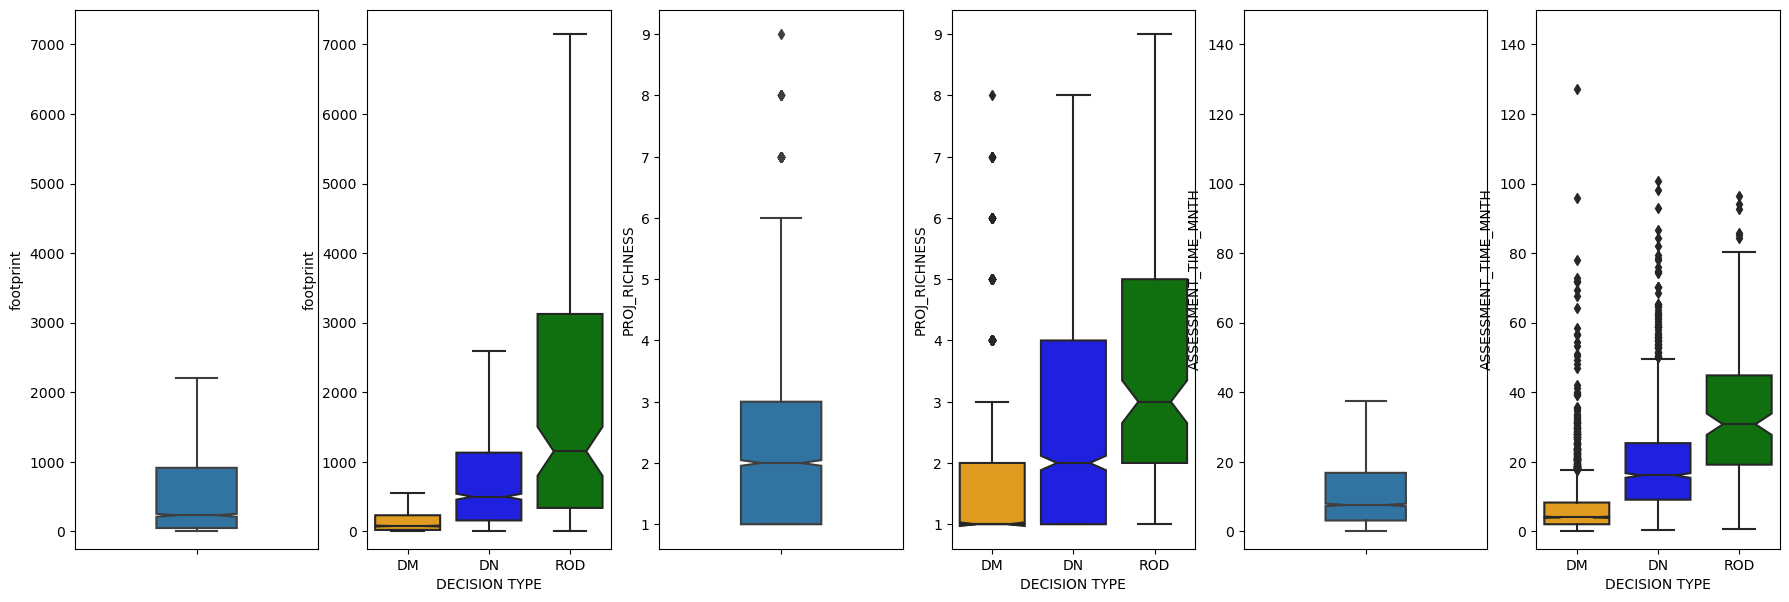

In [97]:
fig, ax = plt.subplots(1, 6, figsize=(22,7), sharex=False, sharey=False)

# Ax[0,0] project area (footprint, violine plot) from smaller dataset (df_foot used to make the nofliers)
ax0 = sns.boxplot(data=df_foot, y="footprint",
               notch=True, showfliers=False, width = 0.33, ax=ax[0])
ax1 = sns.boxplot(data=df_totareaha_nofliers_nepa, x="DECISION TYPE", y="footprint",
               notch=True, showfliers=False, ax=ax[1],
               hue_order=["DM", "DN", "ROD"], palette=["orange", "blue", "green"],
               order=["DM", "DN", "ROD"])
ax0.set_ylim([-250, 7500])
ax1.set_ylim([-250, 7500])

# Ax[0,1] activity type richness, from larger dataset (df)
ax2 = sns.boxplot(data=df, y="PROJ_RICHNESS",
               notch=True, showfliers=True, width = 0.33, ax=ax[2])
ax3 = sns.boxplot(data=df, x="DECISION TYPE", y="PROJ_RICHNESS", # Either numact or PROJ_RICHNESS
            notch=True, ax=ax[3],
           hue_order=["DM", "DN", "ROD"], palette=["orange", "blue", "green"],
           order=["DM", "DN", "ROD"])

# Ax[0,2] assessment time, from smaller dataset (df_foot)
ax4 = sns.boxplot(data=df_totareaha_nofliers_nepa, y="ASSESSMENT_TIME_MNTH",
               notch=True, showfliers=False, width=0.33, ax=ax[4])
ax5 = sns.boxplot(data=df_foot, x="DECISION TYPE", y="ASSESSMENT_TIME_MNTH", 
            notch=True, ax=ax[5],
           hue_order=["DM", "DN", "ROD"], palette=["orange", "blue", "green"],
           order=["DM", "DN", "ROD"])
ax4.set_ylim([-5, 150])
ax5.set_ylim([-5, 150])

#plt.savefig("/Users/kathrynmurenbeeld/Desktop/NEPA_DELAYS/Drafts/Figures/PDFs/areabox_nofliersdf_acttye_20230128v02.pdf", transparent=True)


In [98]:
print(df_foot['DECISION TYPE'].value_counts())
print(df_totareaha_nofliers_nepa['DECISION TYPE'].value_counts())
print(df['DECISION TYPE'].value_counts())

DM     2473
DN     1497
ROD     172
Name: DECISION TYPE, dtype: int64
DM     2166
DN     1315
ROD     155
Name: DECISION TYPE, dtype: int64
DM     2903
DN     1609
ROD     183
Name: DECISION TYPE, dtype: int64


For the above figure, when brought into illustrator to create Figure 2 the axses are removed and the boxplots shifted towards each other. But no resizing or manipulation of the boxes occur aside from adjusting the colors and line widths. Only the first 4 subplots (footprint and PROJ_RICHNESS) are included in figure 2.  

## Take the top 10th percentile of the project area (footprint) and the assessment time


In [100]:
assesstime2 = df_foot['ASSESSMENT_TIME'].values
assesstime2 = assesstime2[~np.isnan(assesstime2)] 

assess_q90, assess_q10 = np.percentile(assesstime2, [90, 10])
print(assess_q90)


footprint2 = df_foot['footprint'].values
footprint2 = footprint2[~np.isnan(footprint2)] 

foot_q90, foot_q10 = np.percentile(footprint2, [90, 10])
print(foot_q90)

assess_topten = df_foot.loc[df_foot['ASSESSMENT_TIME'] >= assess_q90].copy()
foot_topten = df_foot.loc[df_foot['footprint'] >= foot_q90].copy()


893.0
2591.406031026517


In [101]:
print(len(assess_topten)) 
print(len(foot_topten))

416
415


In [102]:
print("assessment time 10th perc = " + "\n" + str(assess_topten['DECISION TYPE'].value_counts()))

print("project area 10th perc = " + "\n" + str(foot_topten['DECISION TYPE'].value_counts()))

print("df_foot total projects = " + "\n" + str(df_foot['DECISION TYPE'].value_counts()))

assessment time 10th perc = 
DN     274
ROD     93
DM      49
Name: DECISION TYPE, dtype: int64
project area 10th perc = 
DN     242
DM     111
ROD     62
Name: DECISION TYPE, dtype: int64
df_foot total projects = 
DM     2473
DN     1497
ROD     172
Name: DECISION TYPE, dtype: int64


In [103]:
foot_topten[['footprint', 'ASSESSMENT_TIME_MNTH']].describe()

,footprint,ASSESSMENT_TIME_MNTH
count,415.000000,415.000000
mean,9613.086368,18.637837
std,16266.210283,17.414852
min,2591.577599,0.427105
25%,3485.509904,6.143737
50%,4553.339458,13.535934
75%,8125.757710,26.184805
max,207835.981752,94.028747


In [104]:
assess_topten[['footprint', 'ASSESSMENT_TIME_MNTH']].describe()

,footprint,ASSESSMENT_TIME_MNTH
count,416.000000,416.000000
mean,2424.136117,44.252014
std,6451.628152,15.089037
min,0.002076,29.338809
25%,147.430329,32.870637
50%,637.200559,39.457906
75%,1789.334318,50.521561
max,71994.345239,127.342916


(0.0, 100.0)

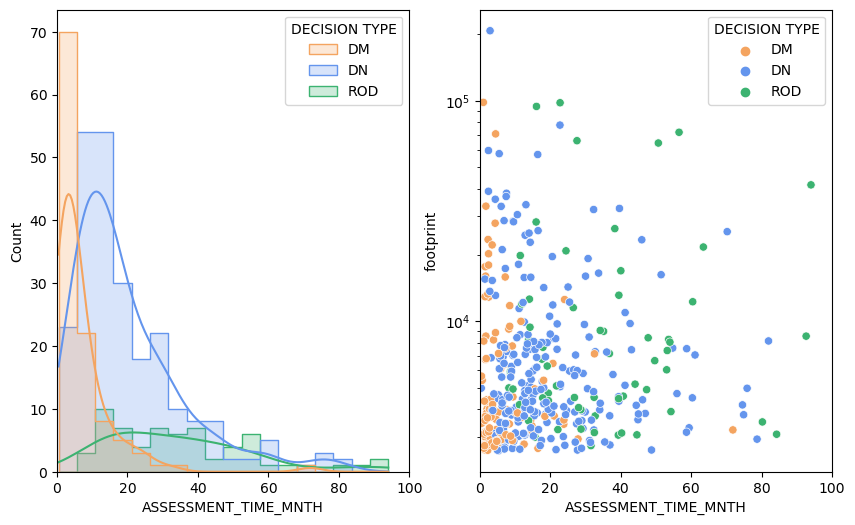

In [108]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharex=True)

ax0 = sns.histplot(data=foot_topten, x="ASSESSMENT_TIME_MNTH", hue="DECISION TYPE", 
             stat='count', element='step', common_norm=False, kde=True, ax=ax[0],
            hue_order=["DM", "DN", "ROD"], palette=["sandybrown", "cornflowerblue", "mediumseagreen"])

ax1 = sns.scatterplot(data=foot_topten, x="ASSESSMENT_TIME_MNTH", y="footprint", hue="DECISION TYPE", 
             ax=ax[1], hue_order=["DM", "DN", "ROD"], palette=["sandybrown", "cornflowerblue", "mediumseagreen"])

ax1.set_yscale('log')
plt.xlim(0,100)


#plt.savefig("/Users/kathrynmurenbeeld/Desktop/NEPA_DELAYS/Drafts/Figures/PDFs/foot_topten_hist-scatter_20230128.pdf", transparent=True)


For the figure on the left above, when brought into Illustrator to create the insert for the figure 2.a the steps are removed and only the KDEs are kept. The overall plot is resized evenly (proportionally) to fit as an insert in panel a, and the x-axis is adjusted to go from 0-55 (count). 

## 7. Survival Curves: Kaplan-Meier


Use the kaplan_meier_estimator to determine the predicted probability of an event occurring as a function of time as a duration. 

For example, the predicted probability of NEPA assessment being signed given the time elapsed from NEPA initiation to the end of the period of observation. 

First calculate the survival probabilities.

In [110]:
time_df_assess, survival_df_assess = kaplan_meier_estimator(
        df['NEPA_COMP2'],
        df['ASSESSMENT_TIME_MNTH'])

time_df_fa, survival_df_fa = kaplan_meier_estimator(
        df['PROJ_INIT'],
        df['NEPA_TO_FIRST_ACT_MAX_MNTH'])

time_df_ctrt, survival_df_ctrt = kaplan_meier_estimator(
        df['PROJ_AWARDED'],
        df['NEPA_TO_CONTRACT_MAX_MNTH'])

In [111]:
time_dm_assess, survival_dm_assess = kaplan_meier_estimator(
        df_dm['NEPA_COMP2'],
        df_dm['ASSESSMENT_TIME_MNTH'])

time_dn_assess, survival_dn_assess = kaplan_meier_estimator(
        df_dn['NEPA_COMP2'],
        df_dn['ASSESSMENT_TIME_MNTH'])

time_rod_assess, survival_rod_assess = kaplan_meier_estimator(
        df_rod['NEPA_COMP2'],
        df_rod['ASSESSMENT_TIME_MNTH'])

In [112]:
time_dm_fa, survival_dm_fa = kaplan_meier_estimator(
        df_dm['PROJ_INIT'],
        df_dm['NEPA_TO_FIRST_ACT_MAX_MNTH'])

time_dn_fa, survival_dn_fa = kaplan_meier_estimator(
        df_dn['PROJ_INIT'],
        df_dn['NEPA_TO_FIRST_ACT_MAX_MNTH'])

time_rod_fa, survival_rod_fa = kaplan_meier_estimator(
        df_rod['PROJ_INIT'],
        df_rod['NEPA_TO_FIRST_ACT_MAX_MNTH'])

In [113]:
time_dm_ctrt, survival_dm_ctrt = kaplan_meier_estimator(
        df_dm['PROJ_AWARDED'],
        df_dm['NEPA_TO_CONTRACT_MAX_MNTH'])

time_dn_ctrt, survival_dn_ctrt = kaplan_meier_estimator(
        df_dn['PROJ_AWARDED'],
        df_dn['NEPA_TO_CONTRACT_MAX_MNTH'])

time_rod_ctrt, survival_rod_ctrt = kaplan_meier_estimator(
        df_rod['PROJ_AWARDED'],
        df_rod['NEPA_TO_CONTRACT_MAX_MNTH'])

Then, create and review the event tables to find the median probability of the event occurring. 

In [117]:
dm_assess_surv = pd.DataFrame({'dm_time': time_dm_assess, 
                            'dm_assess_prob': survival_dm_assess}, columns=['dm_time', 'dm_assess_prob'])
dn_assess_surv = pd.DataFrame({'dn_time': time_dn_assess, 
                            'dn_assess_prob': survival_dn_assess}, columns=['dn_time', 'dn_assess_prob'])
rod_assess_surv = pd.DataFrame({'rod_time': time_rod_assess, 
                            'rod_assess_prob': survival_rod_assess}, columns=['rod_time', 'rod_assess_prob'])


In [118]:
dm_fa_surv = pd.DataFrame({'dm_time': time_dm_fa, 
                            'dm_assess_prob': survival_dm_fa}, columns=['dm_time', 'dm_assess_prob'])
dn_fa_surv = pd.DataFrame({'dn_time': time_dn_fa, 
                            'dn_assess_prob': survival_dn_fa}, columns=['dn_time', 'dn_assess_prob'])
rod_fa_surv = pd.DataFrame({'rod_time': time_rod_fa, 
                            'rod_assess_prob': survival_rod_fa}, columns=['rod_time', 'rod_assess_prob'])

In [119]:
dm_ctrt_surv = pd.DataFrame({'dm_time': time_dm_ctrt, 
                            'dm_assess_prob': survival_dm_ctrt}, columns=['dm_time', 'dm_assess_prob'])
dn_ctrt_surv = pd.DataFrame({'dn_time': time_dn_ctrt, 
                            'dn_assess_prob': survival_dn_ctrt}, columns=['dn_time', 'dn_assess_prob'])
rod_ctrt_surv = pd.DataFrame({'rod_time': time_rod_ctrt, 
                            'rod_assess_prob': survival_rod_ctrt}, columns=['rod_time', 'rod_assess_prob'])

Review each of the event tables generated above to find the median probability of the event occurring. 

In [120]:
# rod_assess_surv

We also want to detemine the *descriptive* median time to assessment, time to first contract awarded, and time to first activity completed. 

In [122]:
# Detemine the median assessment time
med_assess_time = [df_dm['ASSESSMENT_TIME_MNTH'].median(),
                     df_dn['ASSESSMENT_TIME_MNTH'].median(),
                     df_rod['ASSESSMENT_TIME_MNTH'].median()]
# Detemine the median time to first activity
med_fa_time = [df_dm['NEPA_TO_FIRST_ACT_MNTH'].median(),
                     df_dn['NEPA_TO_FIRST_ACT_MNTH'].median(),
                     df_rod['NEPA_TO_FIRST_ACT_MNTH'].median()]
# Determine the median time to the first contract awarded
med_ctc_time = [df_dm['NEPA_TO_CONTRACT_MNTH'].median(),
                     df_dn['NEPA_TO_CONTRACT_MNTH'].median(),
                     df_rod['NEPA_TO_CONTRACT_MNTH'].median()]
# Determine the median planned project duration (time from first (minimum date) activity planned to last (maximum date) activity planned)
med_plan_dur = [df_dm['PROJECT_DUR_PLAN_MNTH'].median(),
                  df_dn['PROJECT_DUR_PLAN_MNTH'].median(),
                  df_rod['PROJECT_DUR_PLAN_MNTH'].median()]
# Detemine the median total project duration (from NEPA initiation to the date planned for the last activity)
med_tot_proj = [df_dm['TOTAL_PROJ_MNTH'].median(),
                  df_dn['TOTAL_PROJ_MNTH'].median(),
                  df_rod['TOTAL_PROJ_MNTH'].median()]


In [123]:
print(med_assess_time)
print(med_fa_time)
print(med_ctc_time)
print(med_plan_dur)
print(med_tot_proj)

[4.008213552361396, 16.0, 31.277207392197127]
[11.15400410677618, 13.503080082135524, 10.841889117043122]
[7.014373716632443, 9.034907597535934, 5.946611909650924]
[36.0, 108.0, 108.0]
[60.0, 132.0, 144.0]


Calculate the errors (standard deviation) for the time to assessment, first activity, and contract awarded.

In [128]:
error_assess = [df_dm['ASSESSMENT_TIME_MNTH'].std(),
                 df_dn['ASSESSMENT_TIME_MNTH'].std(),
                 df_rod['ASSESSMENT_TIME_MNTH'].std()]
error_fa = [df_dm['NEPA_TO_FIRST_ACT_MNTH'].std(),
                 df_dn['NEPA_TO_FIRST_ACT_MNTH'].std(),
                 df_rod['NEPA_TO_FIRST_ACT_MNTH'].std()]
error_ctc = [df_dm['NEPA_TO_CONTRACT_MNTH'].std(),
                 df_dn['NEPA_TO_CONTRACT_MNTH'].std(),
                 df_rod['NEPA_TO_CONTRACT_MNTH'].std()]

**NOTE**: For plotting, need to use a different survival package to show the confidence intervals.

In [129]:
from survive import SurvivalData

km = KaplanMeier()

In [130]:
surv_assess = SurvivalData(time="ASSESSMENT_TIME_MNTH", status="NEPA_COMP2", group="DECISION TYPE",
                    data=df)

surv_ctc = SurvivalData(time="NEPA_TO_CONTRACT_MAX_MNTH", status="PROJ_AWARDED", group="DECISION TYPE",
                    data=df)

surv_fa = SurvivalData(time="NEPA_TO_FIRST_ACT_MAX_MNTH", status="PROJ_INIT", group="DECISION TYPE",
                    data=df)

In [131]:
km_assess = KaplanMeier(conf_type='log-log').fit(surv_assess)
km_fa = KaplanMeier(conf_type='log-log').fit(surv_fa)
km_ctc = KaplanMeier(conf_type='log-log').fit(surv_ctc)

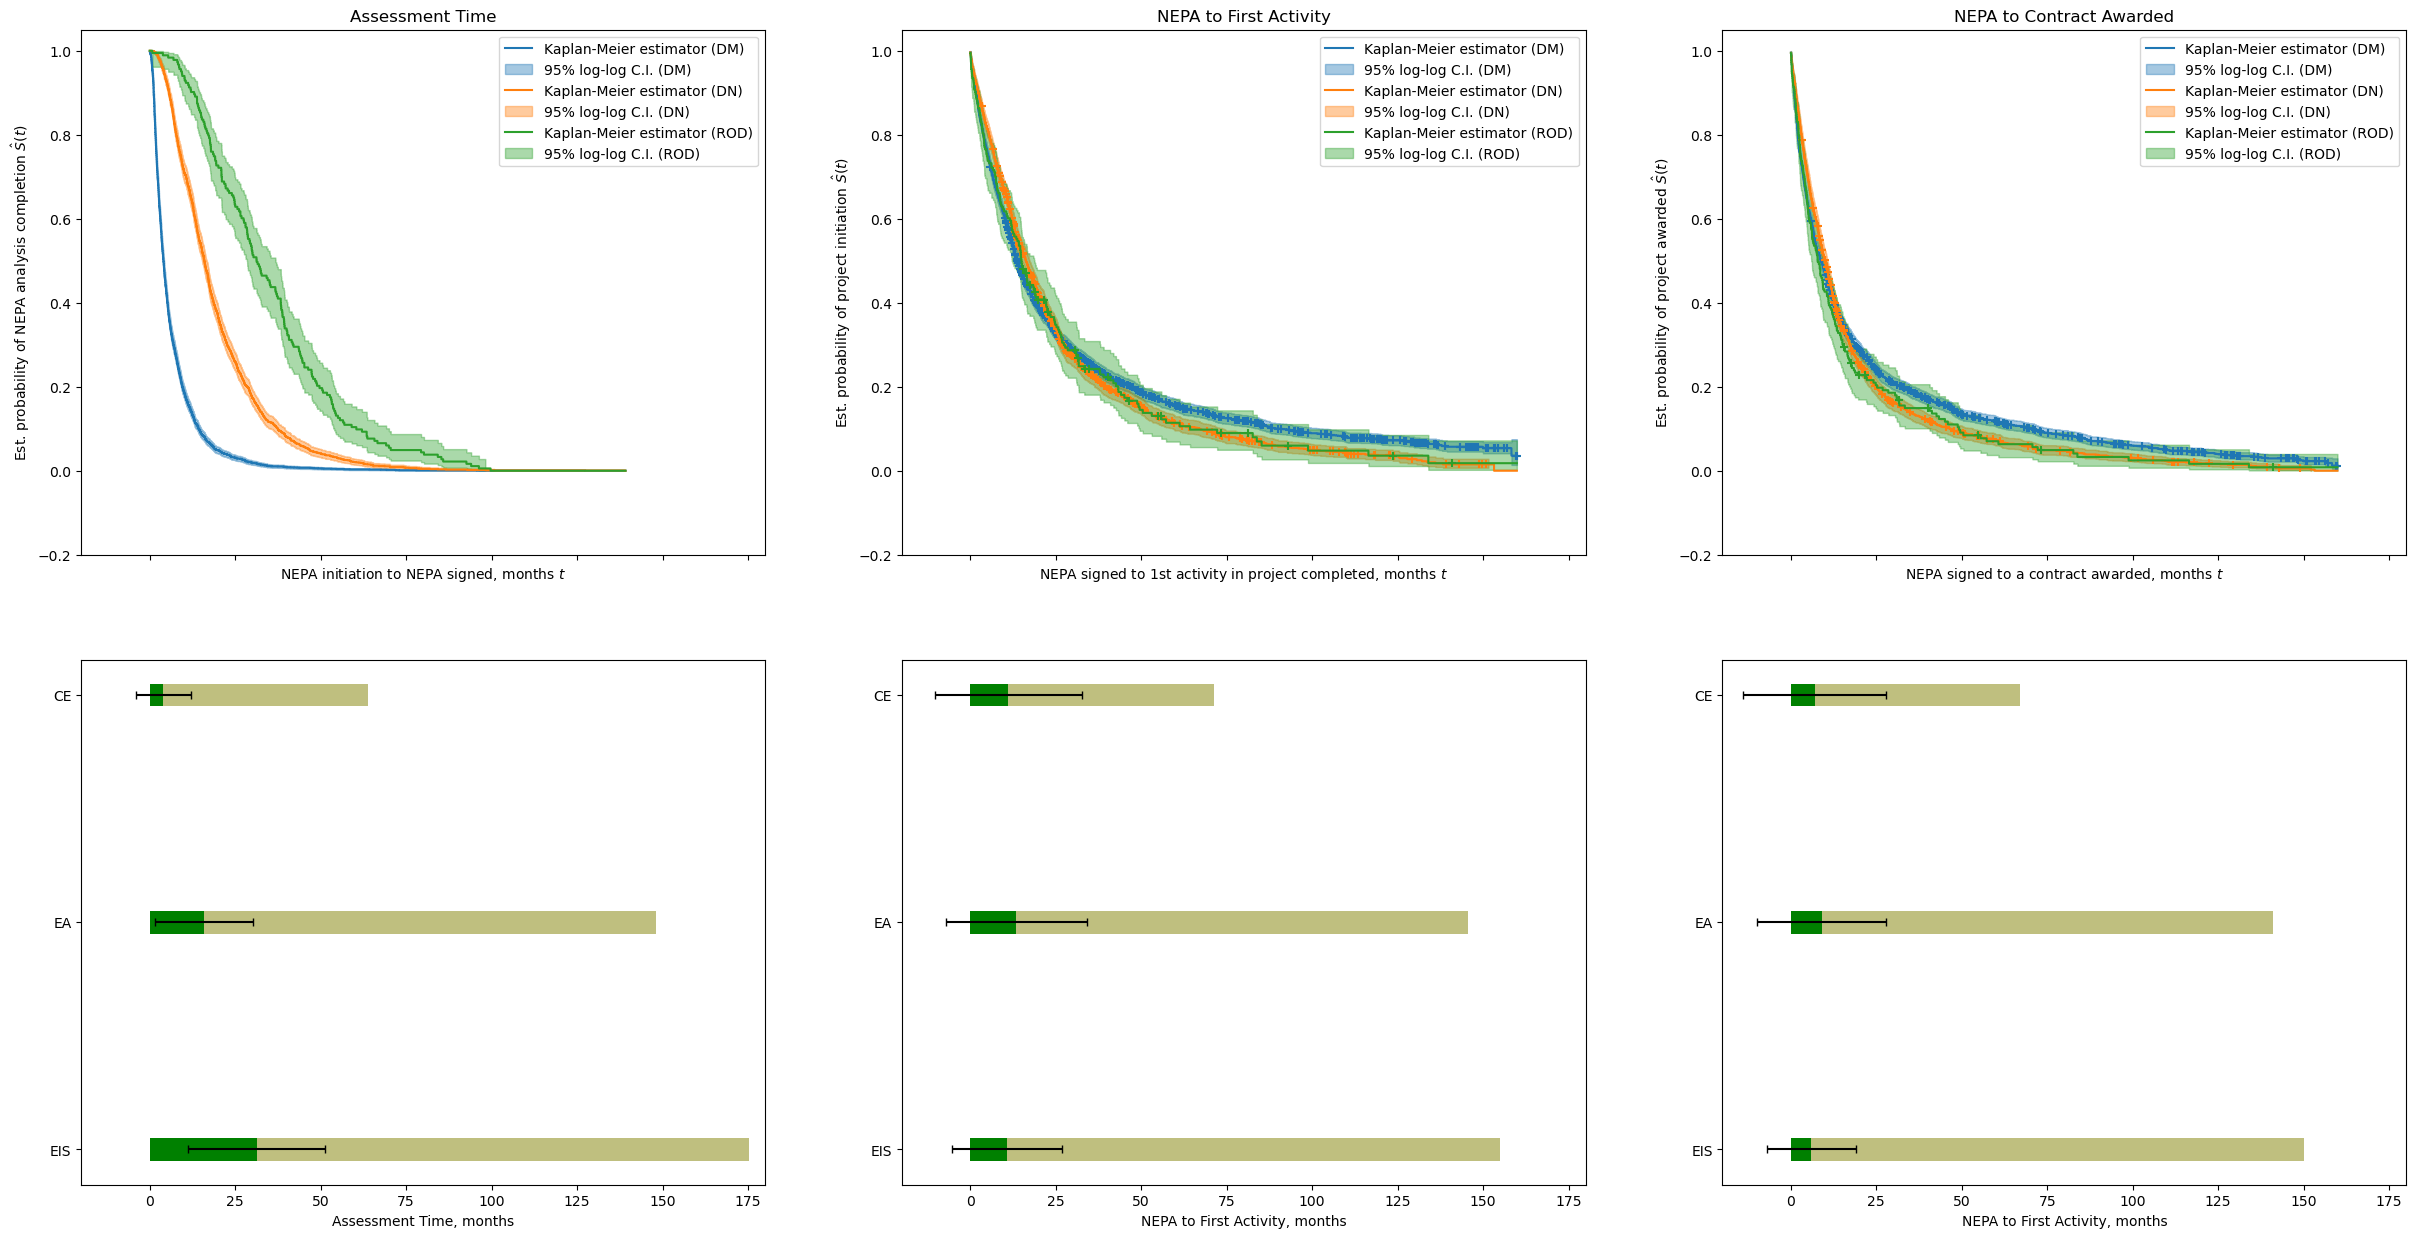

In [132]:
nepa_types = ('CE', 'EA', 'EIS')
y_pos = np.arange(len(nepa_types))

fig, ax = plt.subplots(2, 3, figsize=(30,15), sharex=True)

# Assessment time
km_assess.plot(ax = ax[0,0])

ax[0,0].set_ylabel('Est. probability of NEPA analysis completion $\hat{S}(t)$')
ax[0,0].set_xlabel('NEPA initiation to NEPA signed, months $t$')
ax[0,0].legend(loc='best')
ax[0,0].set_title('Assessment Time')
ax[0,0].set_ylim(-0.2, 1.05)
ax[0,0].set_xlim(xmin=-20, xmax=180)
ax[0,0].margins(x=10)

ax[1,0].barh(y_pos, med_assess_time, 
        xerr=error_assess, ecolor='black', capsize=3, 
        height=0.1, color="green")

ax[1,0].barh(y_pos, med_tot_proj, left=med_assess_time,
        height=0.1, color="olive", alpha=0.5)

ax[1,0].set_yticks(y_pos, labels=nepa_types)
ax[1,0].invert_yaxis()  # labels read top-to-bottom
ax[1,0].set_xlabel('Assessment Time, months')

# Nepa to first act
km_fa.plot(ax = ax[0,1])

ax[0,1].set_ylabel('Est. probability of project initiation $\hat{S}(t)$')
ax[0,1].set_xlabel('NEPA signed to 1st activity in project completed, months $t$')
ax[0,1].legend(loc='best')
ax[0,1].set_title('NEPA to First Activity')
ax[0,1].set_ylim(-0.2, 1.05)
#ax[0,1].set_xlim(0, 180)

ax[1,1].barh(y_pos, med_fa_time, 
        xerr=error_fa, ecolor='black', capsize=3, 
        height=0.1, color="green")

ax[1,1].barh(y_pos, med_tot_proj, left=med_fa_time,
        height=0.1, color="olive", alpha=0.5)

ax[1,1].set_yticks(y_pos, labels=nepa_types)
ax[1,1].invert_yaxis()  # labels read top-to-bottom
ax[1,1].set_xlabel('NEPA to First Activity, months')

# NEPA to contract

km_ctc.plot(ax = ax[0,2])

ax[0,2].set_ylabel('Est. probability of project awarded $\hat{S}(t)$')
ax[0,2].set_xlabel('NEPA signed to a contract awarded, months $t$')
ax[0,2].legend(loc='best')
ax[0,2].set_title('NEPA to Contract Awarded')
ax[0,2].set_ylim(-0.2, 1.05)

ax[1,2].barh(y_pos, med_ctc_time, 
        xerr=error_ctc, ecolor='black', capsize=3, 
        height=0.1, color="green")

#ax[1,2].barh(y_pos, med_plan_dur, left=med_ctc_time, 
ax[1,2].barh(y_pos, med_tot_proj, left=med_ctc_time, 
        #xerr=error_plan_dur, ecolor='olive', capsize=5,
        height=0.1, color="olive", alpha=0.5)

ax[1,2].set_yticks(y_pos, labels=nepa_types)
ax[1,2].invert_yaxis()  # labels read top-to-bottom
ax[1,2].set_xlabel('NEPA to First Activity, months')

plt.xlim(-20,180)
# Remember: transparent=True
#plt.savefig("/Users/kathrynmurenbeeld/Desktop/NEPA_DELAYS/Drafts/Figures/PDFs/km_plan_dur_med_bars_2009_2021_allpurp_v02_20230120.pdf", transparent=True)
plt.show()

The figure above is used to create Figure 1 in the manuscript. It is recolored in Illustrator so that ROD (EIS) are green, DN (EA) are blue, and DM (CE) are orange for the curves and the corresponding stacked bar plots. The bar plots are made slightly thinner and shifted upwards to be included in the same plot as the curves. These are shifted straight up (note that the subplots share an x-axis). 

The probabilities on the x-axis are inversed to allow for ease of interpretation. For example, at time 0, there show be 0 events that have occurred instead of 100% "survival" of the projects to the next time step.

Please note that because the bar plots are horizontally stacked, not overlapping, they do not accurately show the proportion of time spent on NEPA, time from NEPA to award, nor time from NEPA to first activity relative to the planned project duration (time from FY NEPA initiated to the FY the last activity in the project is planned to occur). To account for this, when the figures are brought into Illustrator to adjust colors, text, and make inserts the olive colored (light colored portion) of the bar plots are shifted to the left. The olive colored portions (which shows the total planned time of the project) are shifted so that the bar starts at 0 months where it should start (NEPA initiated). This reflects the correct median planned project durations. 